In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [2]:
def rgb_to_hsi(rgb_img):
    # Convert the RGB image to the [0, 1] range
    rgb_img = np.array(rgb_img, dtype=np.float32) / 255.0

    # Separate the RGB channels
    R, G, B = cv2.split(rgb_img)

    # Calculate Intensity
    I = (R + G + B) / 3.0

    # Calculate Saturation
    num = 1 - (3.0 / (R + G + B + 0.001) * np.minimum(R, np.minimum(G, B)))  # added 0.001 to avoid division by zero
    den = np.sqrt((R - G)**2 + (R - B)*(G - B))
    theta = np.arccos((0.5 * ((R - G) + (R - B))) / (den + 0.001))  # added 0.001 to avoid division by zero
    S = 1 - num

    # Calculate Hue
    H = theta.copy()
    H[B > G] = 2 * np.pi - H[B > G]
    H = H / (2 * np.pi)

    hsi_img = cv2.merge((H, S, I))
    return hsi_img

In [3]:
def calculate_greenness(rgb_img):
    # Convert the image to the [0, 1] range
    rgb_img = np.array(rgb_img, dtype=np.float32) / 255.0

    # Separate the RGB channels
    R, G, B = cv2.split(rgb_img)

    # Calculate the greenness score
    greenness_score = G / (R + G + B + 0.001)  # add 0.001 to avoid division by zero

    return greenness_score


In [4]:
def assign_color_based_on_greenness(greenness_score):
    # Define the color map (you can change these colors as needed)
    color_map = {
        "very_low": [255, 0, 0],  # red
        "low": [255, 165, 0],  # orange
        "medium": [255, 255, 0],  # yellow
        "high": [0, 128, 0],  # green
        "very_high": [0, 0, 255]  # blue
    }

    # Initialize the colored image
    colored_img = np.zeros((*greenness_score.shape, 3), dtype=np.uint8)

    # Assign colors based on greenness level
    colored_img[greenness_score <= 0.20] = color_map["very_low"]
    colored_img[(greenness_score > 0.20) & (greenness_score <= 0.40)] = color_map["low"]
    colored_img[(greenness_score > 0.40) & (greenness_score <= 0.60)] = color_map["medium"]
    colored_img[(greenness_score > 0.60) & (greenness_score <= 0.80)] = color_map["high"]
    colored_img[greenness_score > 0.80] = color_map["very_high"]

    return colored_img

In [ ]:
# Define the base directory for images
# - By default looks for a folder "Images" in the project root
# - You can override with an environment variable: IMAGES_DIR

images_dir = Path(os.getenv("IMAGES_DIR", "Images"))

# Make sure directory exists
if not images_dir.exists():
    raise FileNotFoundError(f"Image directory not found: {images_dir.resolve()}")

# Fetch all JPG/PNG files (works recursively)
image_files = list(images_dir.rglob("*.jpg")) + list(images_dir.rglob("*.png"))

if not image_files:
    raise FileNotFoundError(f"No images found in {images_dir.resolve()}")

print(f"Found {len(image_files)} images in {images_dir}")

# Example: open the first image
image_path = image_files[0]
img = Image.open(image_path)

In [6]:
# Convert the RGB image to HSI
hsi_img = rgb_to_hsi(img)

In [7]:
# Segment the green parts of the image
green_mask = calculate_greenness(hsi_img)

In [8]:
# Generate the colored image based on greenness level
colored_img = assign_color_based_on_greenness(green_mask)

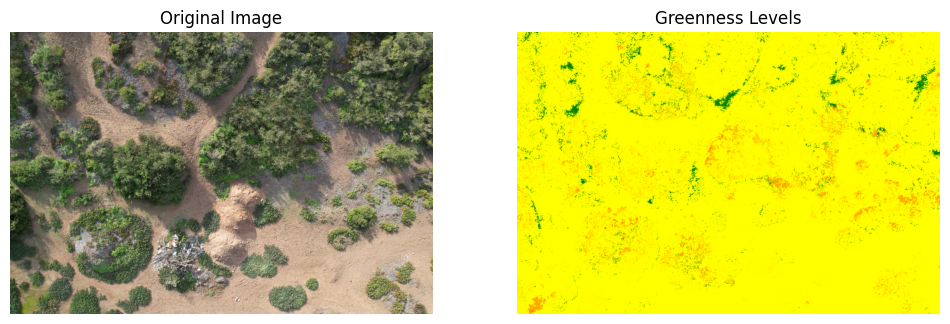

In [9]:
# Display the original image and the colored image side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(colored_img)
ax[1].axis('off')
ax[1].set_title('Greenness Levels')
plt.show()